# 1) Resnet 구현

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

import warnings

# 모든 경고 무시
warnings.filterwarnings('ignore')

def resnet_block_34(inputs, filters, strides=1, downsample=False):
    identity = inputs
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        identity = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x = Add()([x, identity])
    x = Activation('relu')(x)
    return x

def resnet_block_50(inputs, filters, strides=1, downsample=False):
    shortcut = inputs
    strides_temp = strides
    if downsample:
        if not filters == 64:
            strides_temp = 2
    
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters*4, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet_block(inputs, filters, strides=1, downsample=False, is_50=False):
    if is_50:
         x = resnet_block_50(inputs, filters, strides=strides, downsample=downsample)
    else:
         x = resnet_block_34(inputs, filters, strides=strides, downsample=downsample)
    return x

def build_resnet(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = resnet_block(x, filters, strides=strides, downsample=True, is_50=is_50)

        for _ in range(1, num_blocks):
            x = resnet_block(x, filters, is_50=is_50)

    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Resnet_50' if is_50 else 'Resnet_34'
    model = Model(inputs=inputs, outputs=x, name=name)

    model = Model(inputs=inputs, outputs=x)
    return model


# 2) ResNet-34, ResNet-50 Complete Model

In [2]:
#Build ResNet-34
input_shape = (32, 32, 3)
num_classes = 10

resnet_34 = build_resnet(input_shape, False, num_classes )
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
# Build ResNet-50
input_shape = (32, 32, 3)
num_classes = 10

resnet_50 = build_resnet(input_shape, True, num_classes )
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 16, 16, 64)   256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

# 3) 일반 네트워크(plain network) 만들기

In [4]:
def plain_block_34(inputs, filters, strides=1):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block_50(inputs, filters, strides=1):
    strides_temp = 1
    if strides == 2:
        if not filters == 64:
            strides_temp = 2
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block(inputs, filters, strides=1, is_50=False):
    if is_50:
         x = plain_block_50(inputs, filters, strides=strides)
    else:
         x = plain_block_34(inputs, filters, strides=strides)
    return x

def build_plain(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = plain_block(x, filters, strides=strides, is_50=is_50)

        for _ in range(1, num_blocks):
            x = plain_block(x, filters, is_50=is_50)
    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Plain_50' if is_50 else 'Plain_34'
    model = Model(inputs=inputs, outputs=x, name=name)
    return model


In [5]:
#Build Plain-34
input_shape = (224, 224, 3)
num_classes = 10

plain_34 = build_plain(input_shape, False, num_classes, True)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_106 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_107 (Bat (None, 56, 56, 64)        256

In [6]:
#Build Plain-50
input_shape = (224, 224, 3)
num_classes = 10

plain_50 = build_plain(input_shape, True, num_classes, False )
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_139 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_140 (Bat (None, 56, 56, 64)        256

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
### Ablation Study

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import urllib3
import tensorflow_datasets as tfds
try:
    # Load the tf_flowers dataset
    dataset_name = 'cats_vs_dogs'
    train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

    # Preprocess the images and create batches
    batch_size = 32
    def preprocess_image(image, label):
        image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
        image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet
        return image, label

    train_dataset = train_dataset.map(preprocess_image)
    train_dataset = train_dataset.batch(batch_size)
    validation_dataset = validation_dataset.map(preprocess_image)
    validation_dataset = validation_dataset.batch(batch_size)
except:
    print('이미지 다운로드 실패')
    pass
input_shape = (224, 224, 3)
num_classes = 2

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

이미지 다운로드 실패


이미지 다운로드 실패하여  [https://www.microsoft.com/en-us/download/details.aspx?id=54765] 사이트에서 다운받아 사용

 - 오류 수정
```setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip%22)```
 

In [34]:
import PIL.Image as Image
import os
import shutil

def move_file(source_path, destination_path):
    try:
        # 파일 이동
        shutil.move(source_path, destination_path)
        print("File moved successfully!")
    except FileNotFoundError:
        print("Source file not found!")
    except PermissionError:
        print("Permission denied!")
        
# 데이터 경로 설정
train_dir = './data/PetImages/'

# 고양이 데이터셋의 이미지 파일 경로
cat_image_paths = train_dir + 'Cat/' 

# 강아지 데이터셋의 이미지 파일 경로
dog_image_paths = train_dir + 'Dog/' 
# 옮길 경로
destination_path = './data/unknown_Image/'

# 문제가 있는 이미지를 찾기 위한 반복문
for catOrDog in os.listdir(train_dir):
    source_path = train_dir + catOrDog + '/'
    for image_path in  os.listdir(source_path):
        try:
            # 이미지 파일 열기
            image = Image.open(source_path + image_path)
            image.close()
        except:
            # 문제가 있는 이미지 출력
            print("Problematic image:", cat_image_paths + image_path)
            # 파일 옮기기
            move_file(source_path + image_path, destination_path + catOrDog + '/' + image_path)

Problematic image: ./data/PetImages/Cat/666.jpg
File moved successfully!
Problematic image: ./data/PetImages/Cat/11702.jpg
File moved successfully!
Problematic image: ./data/PetImages/Cat/11117.jpg
File moved successfully!


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 전처리 및 증강
image_size = (224, 224)  # 이미지 크기 설정
batch_size = 64

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 스케일 조정
    validation_split=0.2  # 검증 데이터셋 분할 비율 설정
)

# 훈련 데이터셋 및 검증 데이터셋 생성
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',  # 훈련 데이터셋 설정
    shuffle=True
)

validation_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # 검증 데이터셋 설정
    shuffle=True
)


# Checking the size of train_dataset
train_dataset_size = len(train_dataset)
print("Number of images in train_dataset:", train_dataset_size)

# Checking the size of validation_dataset
validation_dataset_size = len(validation_dataset)
print("Number of images in validation_dataset:", validation_dataset_size)

input_shape = (224, 224, 3)
num_classes = 2

Found 19999 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Number of images in train_dataset: 313
Number of images in validation_dataset: 79


In [11]:
resnet_34 = build_resnet(input_shape, False, num_classes, True)
plain_34 = build_plain(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_plain(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
epoch = 15
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/15
313/313 [==============================] - 489s 1s/step - loss: 0.6749 - accuracy: 0.6318 - val_loss: 0.7155 - val_accuracy: 0.5722
Epoch 2/15
313/313 [==============================] - 131s 418ms/step - loss: 0.5824 - accuracy: 0.6915 - val_loss: 1.7221 - val_accuracy: 0.5036
Epoch 3/15
313/313 [==============================] - 131s 417ms/step - loss: 0.5370 - accuracy: 0.7271 - val_loss: 0.8561 - val_accuracy: 0.6148
Epoch 4/15
313/313 [==============================] - 131s 417ms/step - loss: 0.4892 - accuracy: 0.7697 - val_loss: 1.1601 - val_accuracy: 0.5342
Epoch 5/15
313/313 [==============================] - 130s 415ms/step - loss: 0.4450 - accuracy: 0.7930 - val_loss: 5.2558 - val_accuracy: 0.5278
Epoch 6/15
313/313 [==============================] - 131s 417ms/step - loss: 0.3815 - accuracy: 0.8290 - val_loss: 0.8374 - val_accuracy: 0.6517
Epoch 7/15
313/313 [==============================] - 130s 415ms/step - loss: 0.3125 - accuracy: 0.8646 - val_loss: 4.4040 - va

In [14]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/15
313/313 [==============================] - 236s 729ms/step - loss: 0.6866 - accuracy: 0.6451 - val_loss: 0.7300 - val_accuracy: 0.5308
Epoch 2/15
313/313 [==============================] - 225s 719ms/step - loss: 0.6035 - accuracy: 0.6846 - val_loss: 0.8390 - val_accuracy: 0.5508
Epoch 3/15
313/313 [==============================] - 225s 719ms/step - loss: 0.5180 - accuracy: 0.7455 - val_loss: 0.5463 - val_accuracy: 0.7401
Epoch 4/15
313/313 [==============================] - 225s 719ms/step - loss: 0.4432 - accuracy: 0.7933 - val_loss: 0.5813 - val_accuracy: 0.6815
Epoch 5/15
313/313 [==============================] - 225s 720ms/step - loss: 0.3946 - accuracy: 0.8217 - val_loss: 0.5360 - val_accuracy: 0.7465
Epoch 6/15
313/313 [==============================] - 226s 720ms/step - loss: 0.3389 - accuracy: 0.8549 - val_loss: 0.6648 - val_accuracy: 0.7799
Epoch 7/15
313/313 [==============================] - 225s 720ms/step - loss: 0.2887 - accuracy: 0.8776 - val_loss: 1.0704 -

In [15]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/15
313/313 [==============================] - 125s 391ms/step - loss: 0.6980 - accuracy: 0.5317 - val_loss: 0.7412 - val_accuracy: 0.5002
Epoch 2/15
313/313 [==============================] - 123s 391ms/step - loss: 0.6831 - accuracy: 0.5511 - val_loss: 1.7672 - val_accuracy: 0.4600
Epoch 3/15
313/313 [==============================] - 122s 391ms/step - loss: 0.6707 - accuracy: 0.5673 - val_loss: 0.6739 - val_accuracy: 0.5642
Epoch 4/15
313/313 [==============================] - 123s 391ms/step - loss: 0.6576 - accuracy: 0.5895 - val_loss: 1.9442 - val_accuracy: 0.5466
Epoch 5/15
313/313 [==============================] - 123s 391ms/step - loss: 0.6599 - accuracy: 0.5939 - val_loss: 0.9514 - val_accuracy: 0.6060
Epoch 6/15
313/313 [==============================] - 122s 390ms/step - loss: 0.6369 - accuracy: 0.6367 - val_loss: 1.2489 - val_accuracy: 0.5278
Epoch 7/15
313/313 [==============================] - 122s 390ms/step - loss: 0.6084 - accuracy: 0.6707 - val_loss: 1.4371 -

In [16]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/15
313/313 [==============================] - 194s 606ms/step - loss: 0.7042 - accuracy: 0.5221 - val_loss: 0.9458 - val_accuracy: 0.5002
Epoch 2/15
313/313 [==============================] - 187s 598ms/step - loss: 0.6748 - accuracy: 0.5557 - val_loss: 0.6985 - val_accuracy: 0.5014
Epoch 3/15
313/313 [==============================] - 187s 597ms/step - loss: 0.6692 - accuracy: 0.5672 - val_loss: 0.7336 - val_accuracy: 0.5000
Epoch 4/15
313/313 [==============================] - 187s 596ms/step - loss: 0.6616 - accuracy: 0.5766 - val_loss: 0.6730 - val_accuracy: 0.5000
Epoch 5/15
313/313 [==============================] - 186s 595ms/step - loss: 0.6586 - accuracy: 0.5852 - val_loss: 1.1741 - val_accuracy: 0.5344
Epoch 6/15
313/313 [==============================] - 187s 596ms/step - loss: 0.6612 - accuracy: 0.5798 - val_loss: 0.7094 - val_accuracy: 0.5820
Epoch 7/15
313/313 [==============================] - 186s 594ms/step - loss: 0.6610 - accuracy: 0.5849 - val_loss: 0.6841 -

### 시각화

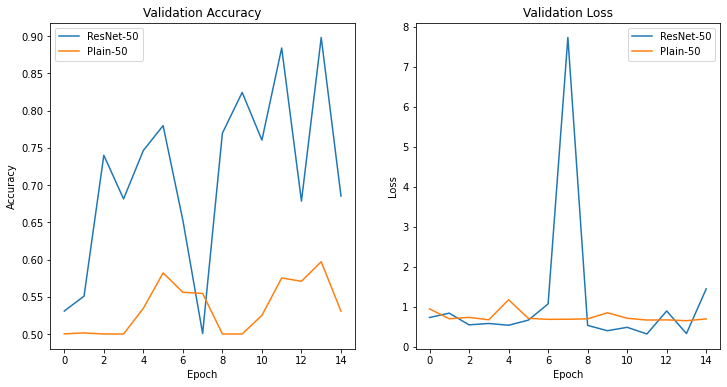

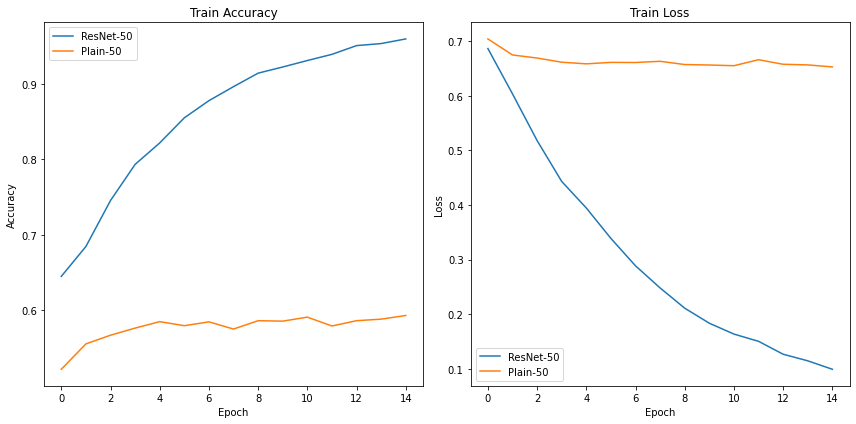

In [17]:
import matplotlib.pyplot as plt
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

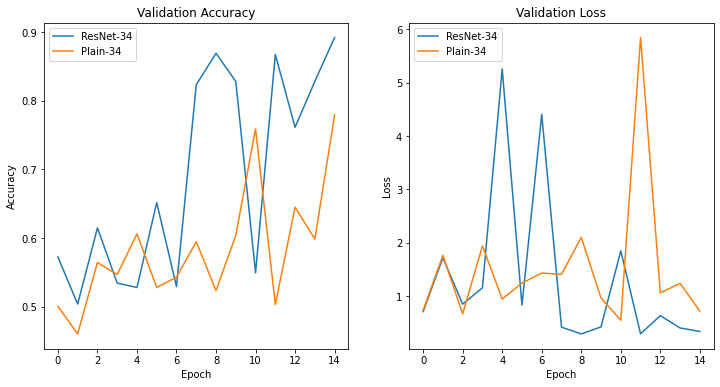

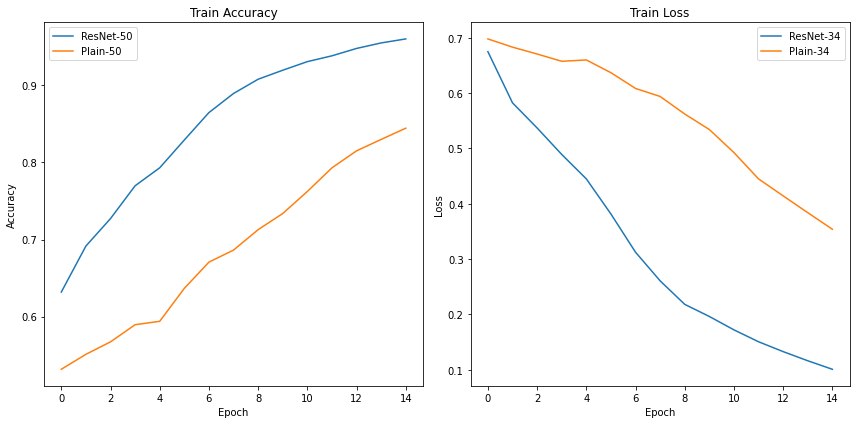

In [18]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

시간 관계상 15epoch만 진행

### Ablation Study
#### tf_flowers datasets

In [19]:
import urllib3
import tensorflow_datasets as tfds

urllib3.disable_warnings()

# Load the tf_flowers dataset
dataset_name = 'tf_flowers'
train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

# Preprocess the images and create batches
batch_size = 32
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
    image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet-50
    return image, label

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.map(preprocess_image)
validation_dataset = validation_dataset.batch(batch_size)
input_shape = (224, 224, 3)
num_classes = 5
epoch = 60

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /aiffel/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [20]:
resnet_34 = build_resnet(input_shape, False, num_classes, True)
plain_34 = build_plain(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_plain(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 25s 220ms/step - loss: 1.5999 - accuracy: 0.4332 - val_loss: 175.9680 - val_accuracy: 0.2289
Epoch 2/60
92/92 [==============================] - 19s 201ms/step - loss: 1.1869 - accuracy: 0.5286 - val_loss: 3.4186 - val_accuracy: 0.4755
Epoch 3/60
92/92 [==============================] - 18s 197ms/step - loss: 1.0973 - accuracy: 0.5657 - val_loss: 1.3858 - val_accuracy: 0.5668
Epoch 4/60
92/92 [==============================] - 18s 194ms/step - loss: 1.0137 - accuracy: 0.6110 - val_loss: 1.3437 - val_accuracy: 0.4864
Epoch 5/60
92/92 [==============================] - 18s 195ms/step - loss: 0.9542 - accuracy: 0.6540 - val_loss: 1.0070 - val_accuracy: 0.6499
Epoch 6/60
92/92 [==============================] - 18s 196ms/step - loss: 0.9146 - accuracy: 0.6614 - val_loss: 1.0213 - val_accuracy: 0.6322
Epoch 7/60
92/92 [==============================] - 18s 197ms/step - loss: 0.9350 - accuracy: 0.6628 - val_loss: 1.2233 - val_accuracy: 0.59

Epoch 58/60
92/92 [==============================] - 18s 197ms/step - loss: 0.0295 - accuracy: 0.9894 - val_loss: 2.2026 - val_accuracy: 0.7125
Epoch 59/60
92/92 [==============================] - 18s 197ms/step - loss: 0.0144 - accuracy: 0.9973 - val_loss: 2.0053 - val_accuracy: 0.6975
Epoch 60/60
92/92 [==============================] - 18s 197ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.7480 - val_accuracy: 0.7398


In [23]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 41s 383ms/step - loss: 1.6821 - accuracy: 0.4312 - val_loss: 1.4951 - val_accuracy: 0.3883
Epoch 2/60
92/92 [==============================] - 33s 355ms/step - loss: 1.3290 - accuracy: 0.5109 - val_loss: 2.2689 - val_accuracy: 0.3120
Epoch 3/60
92/92 [==============================] - 33s 355ms/step - loss: 1.1861 - accuracy: 0.5514 - val_loss: 7.4822 - val_accuracy: 0.5163
Epoch 4/60
92/92 [==============================] - 33s 355ms/step - loss: 1.1727 - accuracy: 0.5637 - val_loss: 1.3018 - val_accuracy: 0.5354
Epoch 5/60
92/92 [==============================] - 33s 356ms/step - loss: 1.0536 - accuracy: 0.6175 - val_loss: 1.6841 - val_accuracy: 0.5041
Epoch 6/60
92/92 [==============================] - 33s 356ms/step - loss: 0.9983 - accuracy: 0.6281 - val_loss: 54.9996 - val_accuracy: 0.3992
Epoch 7/60
92/92 [==============================] - 33s 357ms/step - loss: 0.9226 - accuracy: 0.6529 - val_loss: 1.7559 - val_accuracy: 0.478

Epoch 58/60
92/92 [==============================] - 33s 356ms/step - loss: 1.0781e-04 - accuracy: 1.0000 - val_loss: 1.9709 - val_accuracy: 0.7112
Epoch 59/60
92/92 [==============================] - 33s 356ms/step - loss: 8.9134e-05 - accuracy: 1.0000 - val_loss: 1.9822 - val_accuracy: 0.7112
Epoch 60/60
92/92 [==============================] - 33s 357ms/step - loss: 7.6133e-05 - accuracy: 1.0000 - val_loss: 1.9926 - val_accuracy: 0.7112


In [24]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 21s 198ms/step - loss: 1.6514 - accuracy: 0.2650 - val_loss: 156.2945 - val_accuracy: 0.1880
Epoch 2/60
92/92 [==============================] - 17s 187ms/step - loss: 1.4313 - accuracy: 0.3798 - val_loss: 323.3672 - val_accuracy: 0.1730
Epoch 3/60
92/92 [==============================] - 17s 186ms/step - loss: 1.3369 - accuracy: 0.4210 - val_loss: 4.1592 - val_accuracy: 0.3379
Epoch 4/60
92/92 [==============================] - 17s 183ms/step - loss: 1.3169 - accuracy: 0.4230 - val_loss: 3.4757 - val_accuracy: 0.3338
Epoch 5/60
92/92 [==============================] - 17s 183ms/step - loss: 1.2845 - accuracy: 0.4343 - val_loss: 1.4157 - val_accuracy: 0.3692
Epoch 6/60
92/92 [==============================] - 17s 183ms/step - loss: 1.2723 - accuracy: 0.4448 - val_loss: 1.3447 - val_accuracy: 0.3529
Epoch 7/60
92/92 [==============================] - 17s 184ms/step - loss: 1.2673 - accuracy: 0.4448 - val_loss: 1.4957 - val_accuracy: 0.

Epoch 58/60
92/92 [==============================] - 17s 184ms/step - loss: 0.8814 - accuracy: 0.6645 - val_loss: 2.2798 - val_accuracy: 0.4687
Epoch 59/60
92/92 [==============================] - 17s 184ms/step - loss: 0.8895 - accuracy: 0.6512 - val_loss: 3.5682 - val_accuracy: 0.4414
Epoch 60/60
92/92 [==============================] - 17s 184ms/step - loss: 0.8795 - accuracy: 0.6645 - val_loss: 1.0200 - val_accuracy: 0.5926


In [25]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 32s 300ms/step - loss: 1.7948 - accuracy: 0.2313 - val_loss: 1.6195 - val_accuracy: 0.1785
Epoch 2/60
92/92 [==============================] - 27s 294ms/step - loss: 1.5997 - accuracy: 0.2459 - val_loss: 1.7682 - val_accuracy: 0.2166
Epoch 3/60
92/92 [==============================] - 27s 293ms/step - loss: 1.5685 - accuracy: 0.2772 - val_loss: 1.7094 - val_accuracy: 0.2139
Epoch 4/60
92/92 [==============================] - 27s 292ms/step - loss: 1.5218 - accuracy: 0.2990 - val_loss: 1.9990 - val_accuracy: 0.2125
Epoch 5/60
92/92 [==============================] - 27s 292ms/step - loss: 1.4567 - accuracy: 0.3283 - val_loss: 1.6580 - val_accuracy: 0.2916
Epoch 6/60
92/92 [==============================] - 27s 292ms/step - loss: 1.4237 - accuracy: 0.3549 - val_loss: 1.5153 - val_accuracy: 0.3338
Epoch 7/60
92/92 [==============================] - 27s 292ms/step - loss: 1.3928 - accuracy: 0.3702 - val_loss: 1.4929 - val_accuracy: 0.3569

Epoch 58/60
92/92 [==============================] - 27s 293ms/step - loss: 0.9687 - accuracy: 0.6216 - val_loss: 1.4887 - val_accuracy: 0.5586
Epoch 59/60
92/92 [==============================] - 27s 298ms/step - loss: 0.9345 - accuracy: 0.6410 - val_loss: 1.7930 - val_accuracy: 0.4591
Epoch 60/60
92/92 [==============================] - 27s 290ms/step - loss: 0.9298 - accuracy: 0.6458 - val_loss: 1.0359 - val_accuracy: 0.6199


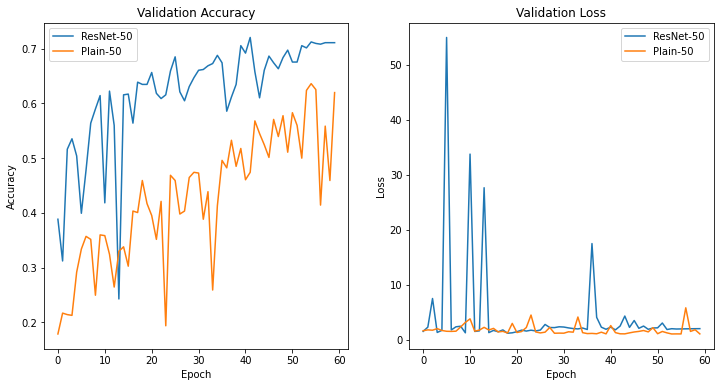

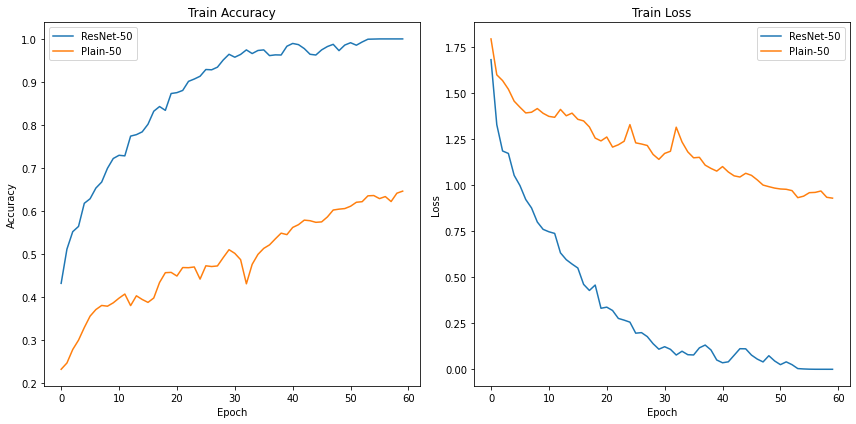

In [26]:
import matplotlib.pyplot as plt
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

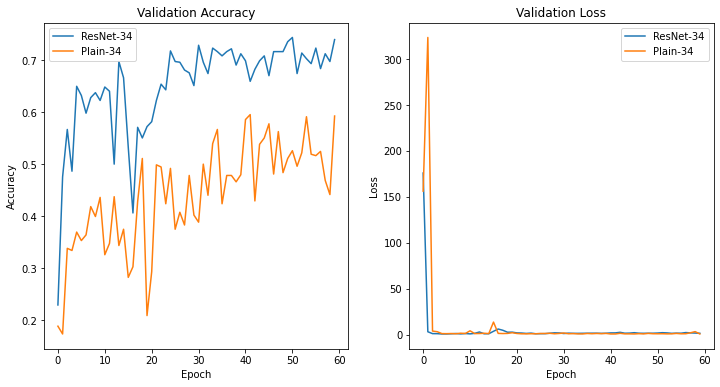

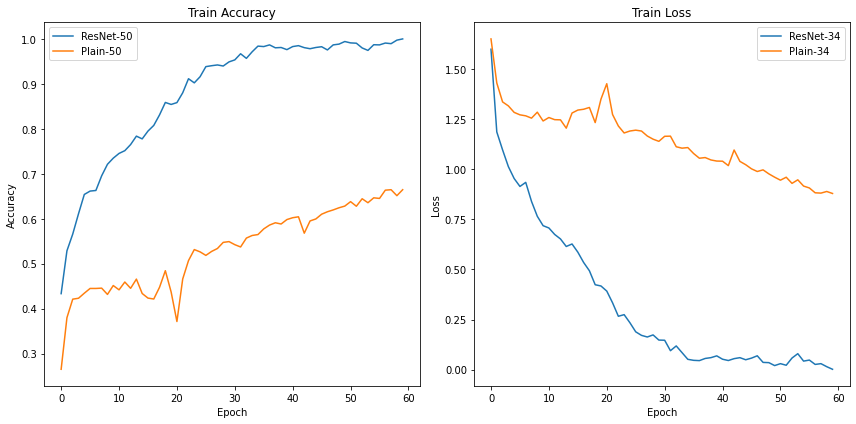

In [27]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()